In [15]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, BatchNormalization, Dropout, Input, concatenate
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
#from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox


In [22]:
# Set the path to your folder containing CSV files
folder_path = '../datasets/'

csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Check if there are any CSV files in the folder
if not csv_files:
    raise ValueError("No CSV files found in the specified folder.")

In [23]:
# Read all CSV files and store them in a dictionary with filenames as keys
list_of_dataframes = {}
for file in csv_files:
    # Extract the file name without extension
    file_name = os.path.splitext(os.path.basename(file))[0]
    # Read the CSV file and assign it to a variable with the file name
    list_of_dataframes[file_name] = pd.read_csv(file)


In [24]:
orders = list_of_dataframes['olist_orders_dataset'].merge(list_of_dataframes['olist_order_items_dataset'], on='order_id')

orders_sellers = list_of_dataframes['olist_sellers_dataset'].merge(list_of_dataframes['olist_order_items_dataset'], on='seller_id')
orders_sellers = orders_sellers.merge(list_of_dataframes['olist_orders_dataset'], on='order_id')
orders_sellers = orders_sellers.merge(list_of_dataframes['olist_products_dataset'], on='product_id')


In [25]:
# Convert the purchase timestamp to datetime
orders_sellers['order_purchase_timestamp'] = pd.to_datetime(orders_sellers['order_purchase_timestamp'])

# Extract week, month, year, and month-year columns
orders_sellers['order_week'] = orders_sellers['order_purchase_timestamp'].dt.to_period('W')
orders_sellers['order_month'] = orders_sellers['order_purchase_timestamp'].dt.month
orders_sellers['order_year'] = orders_sellers['order_purchase_timestamp'].dt.year
orders_sellers['order_monthyear'] = orders_sellers['order_purchase_timestamp'].dt.to_period('M')
orders_sellers['order_dayOfWeek'] = orders_sellers['order_purchase_timestamp'].dt.dayofweek
orders_sellers['order_weekNumber'] = orders_sellers['order_purchase_timestamp'].dt.strftime('%U')




In [26]:
# Group the data by 'order_week' and 'product_category_name' and count the order items
category_counts = orders_sellers.groupby(['order_week', 'product_category_name'])['order_item_id'].count().reset_index()

# Pivot the table to have 'order_week' as index, 'product_category_name' as columns, and counts as values
pivot_table = category_counts.pivot(index='order_week', columns='product_category_name', values='order_item_id')

# Fill missing values with 0 (if there were no orders for a category in a week)
pivot_table = pivot_table.fillna(0)

# Calculate the percentage of order items for each category in each order week
percentage_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Reset the index to have 'order_week' as a regular column
percentage_table = pd.DataFrame(percentage_table.reset_index())

# Add date related exog variables:
exog_data = percentage_table
exog_data['month'] = exog_data['order_week'].dt.month
exog_data['week_number'] = exog_data['order_week'].dt.week
exog_data['year'] = exog_data['order_week'].dt.year

print(exog_data)



product_category_name             order_week  agro_industria_e_comercio  \
0                      2016-08-29/2016-09-04                   0.000000   
1                      2016-09-05/2016-09-11                   0.000000   
2                      2016-09-12/2016-09-18                   0.000000   
3                      2016-09-26/2016-10-02                   0.000000   
4                      2016-10-03/2016-10-09                   0.000000   
..                                       ...                        ...   
90                     2018-08-06/2018-08-12                   0.178412   
91                     2018-08-13/2018-08-19                   0.048900   
92                     2018-08-20/2018-08-26                   0.505051   
93                     2018-08-27/2018-09-02                   0.000000   
94                     2018-09-03/2018-09-09                   0.000000   

product_category_name  alimentos  alimentos_bebidas     artes  \
0                       0.000000  

In [27]:
# Group by order week and count sales
sales_by_weeks = orders_sellers.groupby('order_week').size().reset_index(name='count')

In [28]:
#Merge the exog and target data for EDA
combined_data = pd.merge(sales_by_weeks, exog_data, on='order_week', how='inner')

In [29]:
combined_data.rename(columns={'order_week': 'Week', 'count': 'Sales'}, inplace=True)
# Convert 'Week' to a string representation of the period
combined_data['Week'] = combined_data['Week'].astype(str).str.split('/').str[0]

# Convert 'Week' to datetime
combined_data['Week'] = pd.to_datetime(combined_data['Week'])


### EDA 

<Axes: xlabel='Week', ylabel='Sales'>

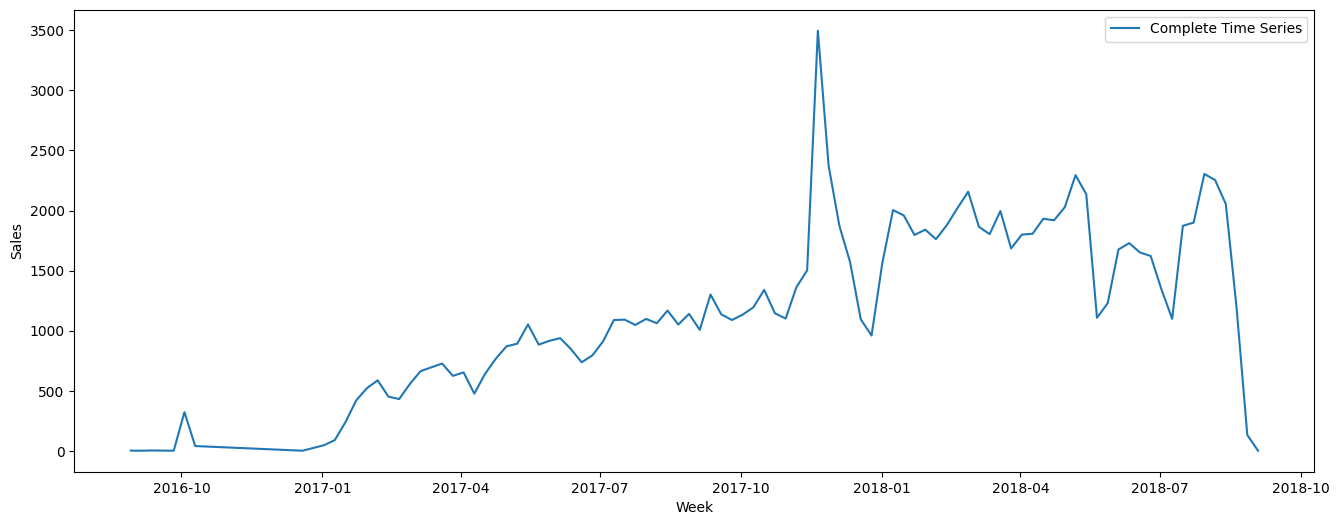

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'sales_time_series' is your target time series
plt.figure(figsize=(16, 6))

# Plot the entire time series
sns.lineplot(x='Week', y='Sales', data=combined_data, label='Complete Time Series')


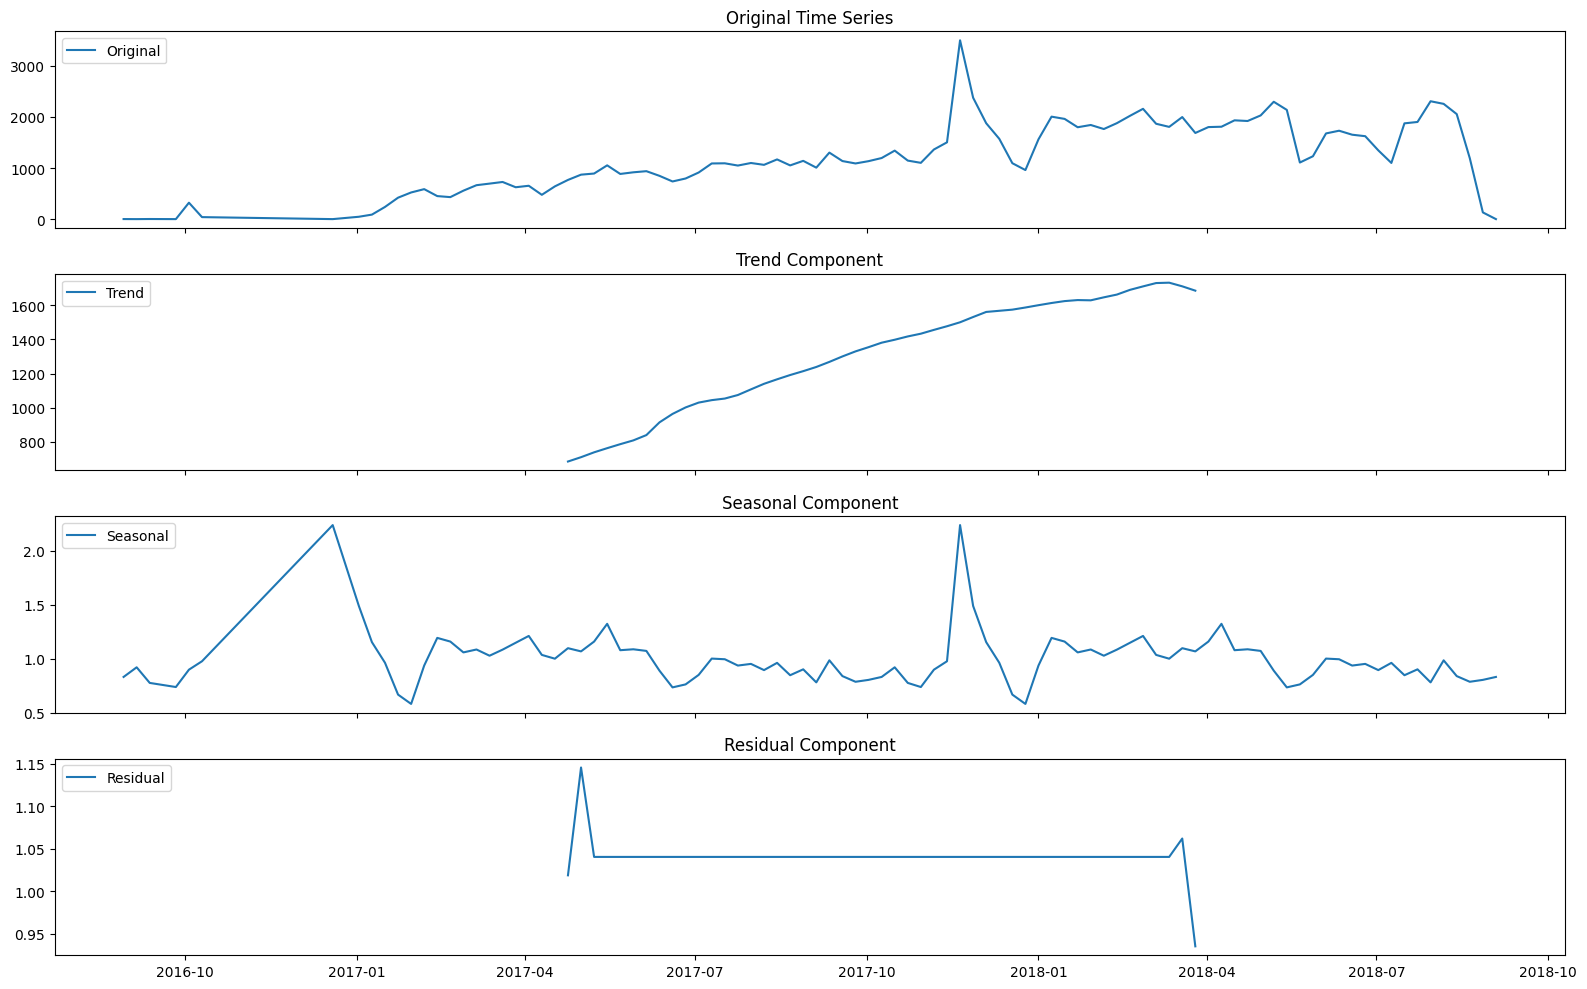

In [31]:


# Handle missing values if needed
combined_data['Sales'].fillna(method='ffill', inplace=True)  # Forward fill for simplicity; choose an appropriate method

# Decompose the time series
result = seasonal_decompose(combined_data['Sales'], model='multiplicative', period=len(combined_data) // 2)

# Plot the components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), sharex=True)

combined_data['Trend'] = result.trend
combined_data['Seasonal'] = result.seasonal
combined_data['Residual'] = result.resid

ax1.plot(combined_data['Week'], combined_data['Sales'], label='Original')
ax1.legend(loc='upper left')
ax1.set_title('Original Time Series')

ax2.plot(combined_data['Week'], combined_data['Trend'], label='Trend')
ax2.legend(loc='upper left')
ax2.set_title('Trend Component')

ax3.plot(combined_data['Week'], combined_data['Seasonal'], label='Seasonal')
ax3.legend(loc='upper left')
ax3.set_title('Seasonal Component')

ax4.plot(combined_data['Week'], combined_data['Residual'], label='Residual')
ax4.legend(loc='upper left')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()


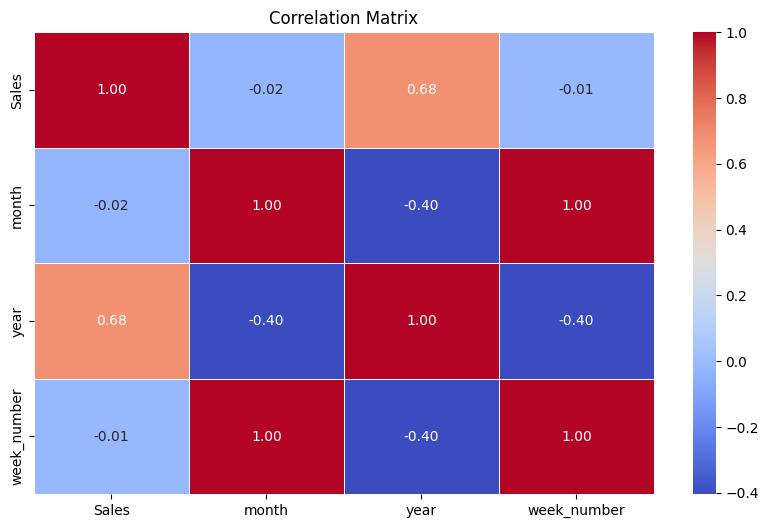

In [32]:
# Correlation matrix
correlation_matrix = combined_data[['Sales', 'month', 'year', 'week_number']].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


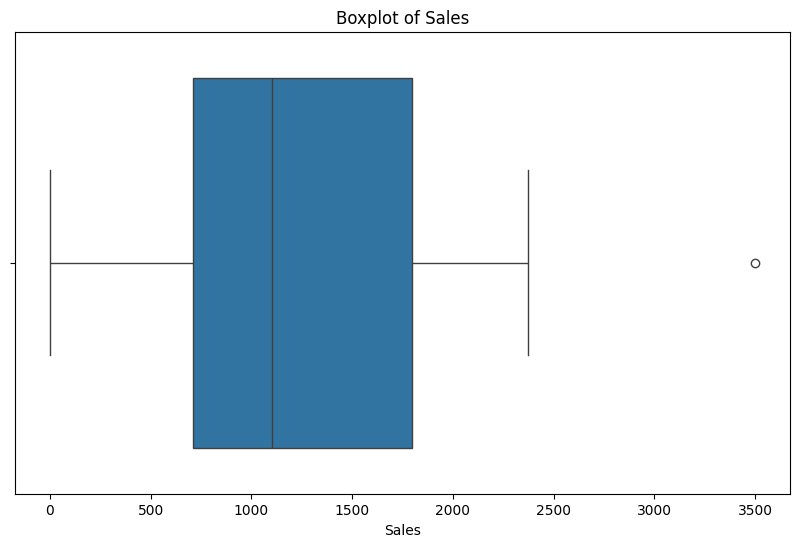

In [33]:
# Boxplot for outlier detection
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_data['Sales'])
plt.title('Boxplot of Sales')
plt.show()


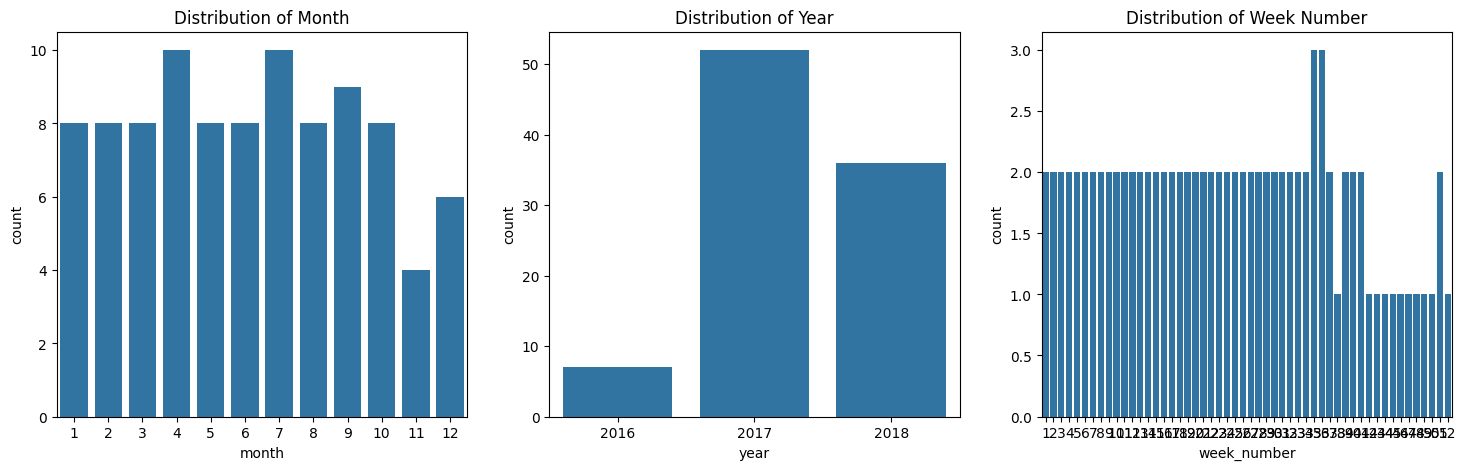

In [34]:
# EDA for exogenous variables
plt.figure(figsize=(18, 5))

# Distribution of 'month'
plt.subplot(1, 3, 1)
sns.countplot(data=exog_data, x='month')
plt.title('Distribution of Month')

# Distribution of 'year'
plt.subplot(1, 3, 2)
sns.countplot(data=exog_data, x='year')
plt.title('Distribution of Year')

# Distribution of 'week_number'
plt.subplot(1, 3, 3)
sns.countplot(data=exog_data, x='week_number')
plt.title('Distribution of Week Number')

plt.show()


### Box-Cox Transformation due to Outliers

Optimal lambda value: 0.6568213222997936


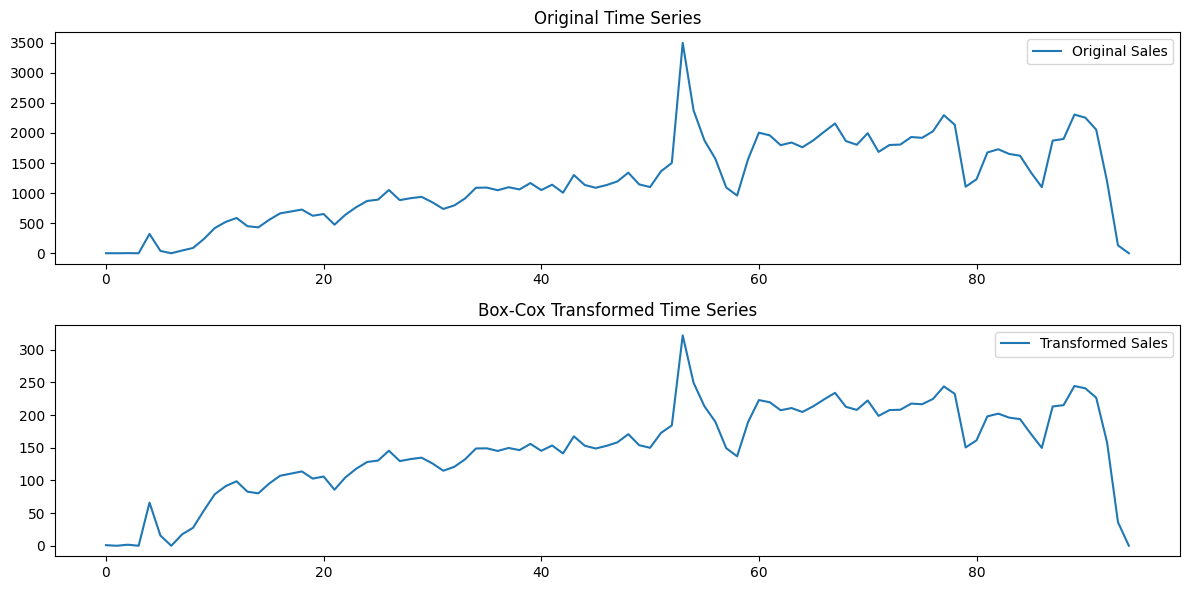

In [35]:
# Assuming 'combined_data' is your DataFrame with the 'Sales' column as the time series
sales_data = combined_data['Sales']

# Apply Box-Cox transformation
transformed_sales, lambda_value = boxcox(sales_data)

# Print the optimal lambda value (it is calculated by the 'boxcox' function)
print(f"Optimal lambda value: {lambda_value}")

# Plot the original and transformed time series
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(sales_data, label='Original Sales')
plt.title('Original Time Series')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(transformed_sales, label='Transformed Sales')
plt.title('Box-Cox Transformed Time Series')
plt.legend()

plt.tight_layout()
plt.show()

### Data Preparation for Modeling

In [36]:
# Label encoding of categorical variables
label_encoder_month = LabelEncoder()
label_encoder_year = LabelEncoder()
label_encoder_week_number = LabelEncoder()

exog_data['month'] = label_encoder_month.fit_transform(exog_data['month'])
exog_data['year'] = label_encoder_year.fit_transform(exog_data['year'])
exog_data['week_number'] = label_encoder_week_number.fit_transform(exog_data['week_number'])

In [37]:
# Select the sales data for modeling
category_data = sales_by_weeks[['order_week', 'count']].rename(columns={'order_week': 'ds', 'count': 'y'})

# Create a time series object
sales_time_series = category_data.set_index('ds')

#Prepare exogenous variables array
exogenous_vars = np.array(exog_data)[:,2:]


In [38]:
original_y = sales_time_series['y']
sales_time_series['y'] = transformed_sales
sales_time_series

,y
ds,
2016-08-29/2016-09-04,0.877872
2016-09-05/2016-09-11,0.000000
2016-09-12/2016-09-18,1.610341
2016-09-26/2016-10-02,0.000000
2016-10-03/2016-10-09,66.049390
...,...
2018-08-06/2018-08-12,241.051588
2018-08-13/2018-08-19,226.689979
2018-08-20/2018-08-26,158.108281


In [39]:
# Define the sequence length and create sequences
sequence_length = 10  # You can adjust this as needed
sequences = []
target_values = []
reshaped_exog_vars = np.empty((len(sales_time_series) - sequence_length, sequence_length, exogenous_vars.shape[1]))

for i in range(len(sales_time_series) - sequence_length):
    seq = sales_time_series.iloc[i:i + sequence_length].values
    target = sales_time_series.iloc[i + sequence_length]
    reshaped_exog_vars[i] = exogenous_vars[i:i + sequence_length]
    sequences.append(seq)
    target_values.append(target)

# Convert lists to numpy arrays
sequences = np.array(sequences)
target_values = np.array(target_values)

# Reshape sequences for LSTM
sequences = sequences.reshape(-1, sequence_length, 1)




In [40]:
# Normalize the numerical variables
sequences = (sequences - sequences.mean()) / sequences.std()
target_values = (target_values - target_values.mean()) / target_values.std()


#### Model Building

In [41]:
def create_lstm_model(units, dropout_rate):

    num_exogenous_vars = train_exog_data.shape[2]

    # Create input layers for the time series data and exogenous variables
    time_series_input = Input(shape=(sequence_length, 1), name="time_series_input")
    exogenous_input = Input(shape=(sequence_length, num_exogenous_vars), name="exogenous_input")
    # LSTM layers for the time series data
    lstm_layer = LSTM(units=units, return_sequences=True)(time_series_input)
    lstm_layer = BatchNormalization()(lstm_layer)
    lstm_layer = LSTM(units=units, return_sequences=True)(lstm_layer)
    lstm_layer = Dropout(dropout_rate)(lstm_layer)

    # Merge time series and exogenous inputs
    merged = concatenate([lstm_layer, exogenous_input], axis=-1)

    # Additional dense layers
    merged = Dense(32, activation='relu')(merged)
    merged = Dropout(dropout_rate)(merged)
    output_layer = Dense(1)(merged)

    # Create the model
    model = Model(inputs=[time_series_input, exogenous_input], outputs=output_layer)

    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=['mean_absolute_error']
    )

    return model


#### Train-Test Split

In [42]:
# Split the data into training and testing sets
split_ratio = 0.8
split_index = round(split_ratio * sequences.shape[0])

train_sequences = sequences[:split_index, :]
train_target_values = target_values[:split_index]

test_sequences = sequences[split_index:, :]
test_target_values = target_values[split_index:]

train_exog_data = reshaped_exog_vars[:split_index]
test_exog_data = reshaped_exog_vars[split_index:]

print(train_exog_data.shape)

(68, 10, 75)


#### Hyperparameter Tuning

In [43]:
# Define the hyperparameters
units = [32, 64, 128]
dropout_rates = [0.0, 0.2, 0.4]
batch_size = [32, 64]
epochs = [500, 1000]

In [44]:
# Create a TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Initialize variables to keep track of the best model and its score
best_model = None
best_score = np.inf

# Perform cross-validation
for unit in units:
    for dropout_rate in dropout_rates:
        for bs in batch_size:
            for epoch in epochs:
                mse_scores = []

                for train_index, val_index in tscv.split(train_sequences):
                    X_train, X_val = train_sequences[train_index], train_sequences[val_index]
                    exog_train, exog_val = train_exog_data[train_index], train_exog_data[val_index]
                    y_train, y_val = train_target_values[train_index], train_target_values[val_index]

                    # Create the LSTM model
                    model = create_lstm_model(unit, dropout_rate)

                    # Fit the model
                    model.fit([X_train, exog_train], y_train, epochs=epoch, batch_size=bs, verbose=0)

                    # Make predictions
                    val_predictions = model.predict([X_val, exog_val])
                    val_predictions = val_predictions[:, -1, :]
                    val_mse = mean_squared_error(y_val, val_predictions)
                    mse_scores.append(val_mse)

                # Calculate the mean MSE across folds
                mean_mse = np.mean(mse_scores)

                # Check if this combination is the best
                if mean_mse < best_score:
                    best_score = mean_mse
                    best_model = model
                    best_unit = unit
                    best_dropout = dropout_rate
                    best_batch_size = bs,
                    best_epoch = epoch

                print(f"Units: {best_unit}, Dropout rate: {best_dropout}, Batch size: {best_batch_size}, Epochs: {best_epoch}")
                print(f"Best average MSE: {best_score}")


1/1 [==============================] - 1s 1s/step
Units: 32, Dropout rate: 0.0, Batch size: (32,), Epochs: 500
Best average MSE: 0.7964535544466956
1/1 [==============================] - 1s 1s/step
Units: 32, Dropout rate: 0.0, Batch size: (32,), Epochs: 500
Best average MSE: 0.7964535544466956
1/1 [==============================] - 1s 1s/step
Units: 32, Dropout rate: 0.0, Batch size: (32,), Epochs: 500
Best average MSE: 0.7964535544466956
1/1 [==============================] - 1s 1s/step
Units: 32, Dropout rate: 0.0, Batch size: (32,), Epochs: 500
Best average MSE: 0.7964535544466956
1/1 [==============================] - 1s 1s/step
Units: 32, Dropout rate: 0.2, Batch size: (32,), Epochs: 500
Best average MSE: 0.6324445403379232
1/1 [==============================] - 1s 1s/step
Units: 32, Dropout rate: 0.2, Batch size: (32,), Epochs: 500
Best average MSE: 0.6324445403379232
1/1 [==============================] - 1s 1s/step
Units: 32, Dropout rate: 0.2, Batch size: (32,), Epochs: 500
B

### Model Training with Best Hyperparameter Values

In [45]:
del model

model = create_lstm_model(best_unit, best_dropout)

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mean_absolute_error']
)

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=100,         
    restore_best_weights=True  
)

model.fit(
    [train_sequences, train_exog_data],
    train_target_values,
    epochs=best_epoch,
    batch_size=best_batch_size[0],
    validation_split=0.2,
    verbose=1,
    #callbacks=[early_stopping]
    )

# Evaluate the model on the test data
evaluation = model.evaluate([test_sequences, test_exog_data], test_target_values)
print(f"Mean Absolute Error (MAE): {evaluation[1]}")
print(f"Mean Squared Error (MSE): {evaluation[0]}")


Epoch 1/1000
1/1 [==============================] - 11s 11s/step - loss: 5.5441 - mean_absolute_error: 1.4838 - val_loss: 5.9342 - val_mean_absolute_error: 2.3586
Epoch 2/1000
1/1 [==============================] - 0s 155ms/step - loss: 4.3792 - mean_absolute_error: 1.3456 - val_loss: 5.6397 - val_mean_absolute_error: 2.2960
Epoch 3/1000
1/1 [==============================] - 0s 141ms/step - loss: 4.3164 - mean_absolute_error: 1.2973 - val_loss: 5.7378 - val_mean_absolute_error: 2.3212
Epoch 4/1000
1/1 [==============================] - 0s 132ms/step - loss: 4.2099 - mean_absolute_error: 1.2971 - val_loss: 5.8173 - val_mean_absolute_error: 2.3424
Epoch 5/1000
1/1 [==============================] - 0s 139ms/step - loss: 3.5520 - mean_absolute_error: 1.2554 - val_loss: 5.8050 - val_mean_absolute_error: 2.3431
Epoch 6/1000
1/1 [==============================] - 0s 119ms/step - loss: 3.3695 - mean_absolute_error: 1.1709 - val_loss: 5.6683 - val_mean_absolute_error: 2.3155
Epoch 7/1000
1/1 

### Predictions

In [46]:
# Reshape test_sequences
train_sequences_reshaped = train_sequences.reshape(train_sequences.shape[0], train_sequences.shape[1], 1)
test_sequences_reshaped = test_sequences.reshape(test_sequences.shape[0], test_sequences.shape[1], 1)

# Make predictions
predictions = model.predict([test_sequences, test_exog_data])

# Define the variable fitted_and_predictions based on your LSTM model's predictions
fitted_and_predictions = np.concatenate([model.predict([train_sequences,train_exog_data]), predictions])

# Recover the unnormalized values
#fitted_and_predictions = (fitted_and_predictions * target_values.std()) + target_values.mean()

# Convert the arrays to 1-dimensional
train_target_values_1d = train_target_values.flatten()
test_target_values_1d = test_target_values.flatten()
fitted_and_predictions_1d = fitted_and_predictions[:,0].flatten()


3/3 [==============================] - 0s 21ms/step


In [47]:
# Reshape train_sequences and test_sequences
train_sequences_reshaped = train_sequences.reshape(train_sequences.shape[0], train_sequences.shape[1], 1)
test_sequences_reshaped = test_sequences.reshape(test_sequences.shape[0], test_sequences.shape[1], 1)

# Make predictions
train_predictions = model.predict([train_sequences_reshaped, train_exog_data])
test_predictions = model.predict([test_sequences_reshaped, test_exog_data])

# Concatenate predictions
fitted_and_predictions = np.concatenate([train_predictions.flatten(), test_predictions.flatten()])


1/1 [==============================] - 0s 59ms/step


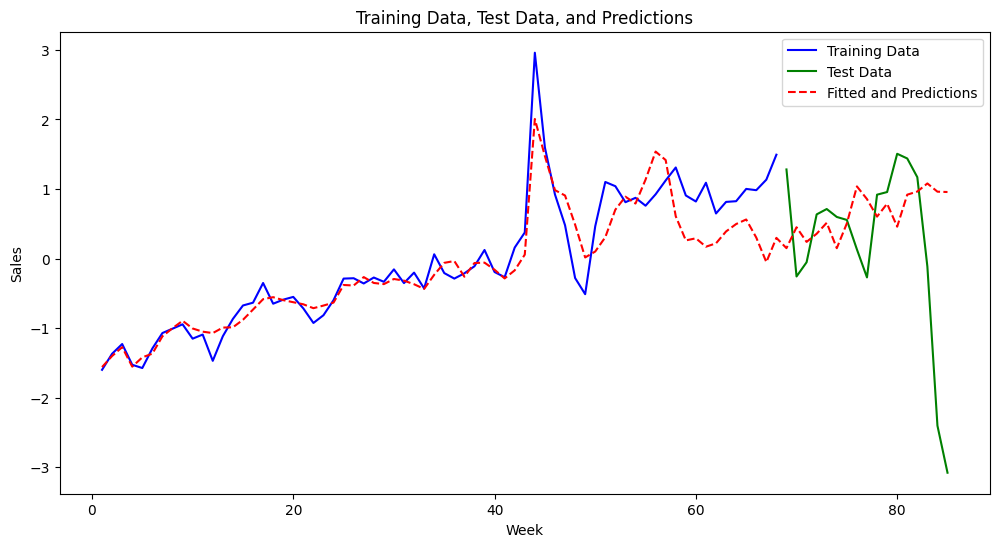

In [48]:
# Create a data frame for plotting
combined_data = pd.DataFrame({
    'Week': range(1, len(train_target_values_1d) + len(test_target_values_1d) + 1),
    'Data': np.concatenate([train_target_values_1d, test_target_values_1d]),
    'Fitted and Predictions': fitted_and_predictions_1d
})

# Create labels for training and test data
combined_data['Label'] = ['Training Data'] * len(train_target_values_1d) + ['Test Data'] * len(test_target_values_1d)

# Plot the combined data with labels
plt.figure(figsize=(12, 6))
plt.plot(combined_data[combined_data['Label'] == 'Training Data']['Week'], combined_data[combined_data['Label'] == 'Training Data']['Data'], label='Training Data', color='blue')
plt.plot(combined_data[combined_data['Label'] == 'Test Data']['Week'], combined_data[combined_data['Label'] == 'Test Data']['Data'], label='Test Data', color='green')
plt.plot(combined_data['Week'], combined_data['Fitted and Predictions'], label='Fitted and Predictions', color='red', linestyle='dashed')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.title('Training Data, Test Data, and Predictions')
plt.legend()
plt.show()

-----------------------